In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import csv
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
sys.path.append('')  # To find local version
import projection1
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
def get_ax(rows=1, cols=1, size=13):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [5]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [6]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 6, 10: 9, 11: 7, 12: 0, 13: 8, 14: 5, 15: 9, 16: 0, 17: 10, 18: 11, 19: 12, 20: 0, 21: 13, 22: 0, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 19, 34: 20, 35: 21, 36: 22, 37: 23, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [7]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIGOGN1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIGOGN1_Bedroom_id0
3FO4MMIGOGN1_Bedroom_id1
3FO4MMIGOGN1_Bedroom_id2
3FO4MMIGOGN1_Bedroom_id3
3FO4MMIGOGN1_Bedroom_id4
3FO4MMIGOGN1_Bedroom_id5
3FO4MMIGOGN1_Bedroom_id6
3FO4MMIGOGN1_Bedroom_id7
3FO4MMIGOGN1_Bedroom_id8
3FO4MMIGOGN1_Bedroom_id9
3FO4MMIGOGN1_Bedroom_id10
3FO4MMIGOGN1_Bedroom_id11
3FO4MMIGOGN1_Bedroom_id12
3FO4MMIGOGN1_Bedroom_id13
3FO4MMIGOGN1_Bedroom_id14
3FO4MMIGOGN1_Bedroom_id15
3FO4MMIGOGN1_Bedroom_id16
3FO4MMIGOGN1_Bedroom_id17
3FO4MMIGOGN1_Bedroom_id18
3FO4MMIGOGN1_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6CI92_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6CI92_Living_room_id0
3FO4MKV6CI92_Living_room_id1
3FO4MKV6CI92_Living_room

3FO4MKR81JA9_Living_room_id13
3FO4MKR81JA9_Living_room_id14
3FO4MKR81JA9_Living_room_id15
3FO4MKR81JA9_Living_room_id16
3FO4MKR81JA9_Living_room_id17
3FO4MKR81JA9_Living_room_id18
3FO4MKR81JA9_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M9TWNCQR_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M9TWNCQR_Guest_room_id0
3FO4M9TWNCQR_Guest_room_id1
3FO4M9TWNCQR_Guest_room_id2
3FO4M9TWNCQR_Guest_room_id3
3FO4M9TWNCQR_Guest_room_id4
3FO4M9TWNCQR_Guest_room_id5
3FO4M9TWNCQR_Guest_room_id6
3FO4M9TWNCQR_Guest_room_id7
3FO4M9TWNCQR_Guest_room_id8
3FO4M9TWNCQR_Guest_room_id9
3FO4M9TWNCQR_Guest_room_id10
3FO4M9TWNCQR_Guest_room_id11
3FO4M9TWNCQR_Guest_room_id12
3FO4M9TWNCQR_Guest_room_id13
3FO4M9TWNCQR_Guest_room_id14
3FO4M9TWNCQR_Guest_room_id15
3FO4M9TWNCQR_Guest_room_id16
3FO4M9TWNCQR_Guest_room_id17
3FO4M9TWNCQR_Guest_room_id18
3FO4M9TWNCQR_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/Interior

3FO4MKR8MTWM_Dining_room_id0
3FO4MKR8MTWM_Dining_room_id1
3FO4MKR8MTWM_Dining_room_id2
3FO4MKR8MTWM_Dining_room_id3
3FO4MKR8MTWM_Dining_room_id4
3FO4MKR8MTWM_Dining_room_id5
3FO4MKR8MTWM_Dining_room_id6
3FO4MKR8MTWM_Dining_room_id7
3FO4MKR8MTWM_Dining_room_id8
3FO4MKR8MTWM_Dining_room_id9
3FO4MKR8MTWM_Dining_room_id10
3FO4MKR8MTWM_Dining_room_id11
3FO4MKR8MTWM_Dining_room_id12
3FO4MKR8MTWM_Dining_room_id13
3FO4MKR8MTWM_Dining_room_id14
3FO4MKR8MTWM_Dining_room_id15
3FO4MKR8MTWM_Dining_room_id16
3FO4MKR8MTWM_Dining_room_id17
3FO4MKR8MTWM_Dining_room_id18
3FO4MKR8MTWM_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MASYSNWN_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MASYSNWN_Dining_room_id0
3FO4MASYSNWN_Dining_room_id1
3FO4MASYSNWN_Dining_room_id2
3FO4MASYSNWN_Dining_room_id3
3FO4MASYSNWN_Dining_room_id4
3FO4MASYSNWN_Dining_room_id5
3FO4MASYSNWN_Dining_room_id6
3FO4MASYSNWN_Dining_room_id7
3FO4

3FO4MBA3JYJQ_Dining_room_id12
3FO4MBA3JYJQ_Dining_room_id13
3FO4MBA3JYJQ_Dining_room_id14
3FO4MBA3JYJQ_Dining_room_id15
3FO4MBA3JYJQ_Dining_room_id16
3FO4MBA3JYJQ_Dining_room_id17
3FO4MBA3JYJQ_Dining_room_id18
3FO4MBA3JYJQ_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIHCUU1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIHCUU1_Bedroom_id0
3FO4MMIHCUU1_Bedroom_id1
3FO4MMIHCUU1_Bedroom_id2
3FO4MMIHCUU1_Bedroom_id3
3FO4MMIHCUU1_Bedroom_id4
3FO4MMIHCUU1_Bedroom_id5
3FO4MMIHCUU1_Bedroom_id6
3FO4MMIHCUU1_Bedroom_id7
3FO4MMIHCUU1_Bedroom_id8
3FO4MMIHCUU1_Bedroom_id9
3FO4MMIHCUU1_Bedroom_id10
3FO4MMIHCUU1_Bedroom_id11
3FO4MMIHCUU1_Bedroom_id12
3FO4MMIHCUU1_Bedroom_id13
3FO4MMIHCUU1_Bedroom_id14
3FO4MMIHCUU1_Bedroom_id15
3FO4MMIHCUU1_Bedroom_id16
3FO4MMIHCUU1_Bedroom_id17
3FO4MMIHCUU1_Bedroom_id18
3FO4MMIHCUU1_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MDGXTCM7_D

Done (t=0.00s)
creating index...
index created!
3FO4MGLXKS4M_Dining_room_id0
3FO4MGLXKS4M_Dining_room_id1
3FO4MGLXKS4M_Dining_room_id2
3FO4MGLXKS4M_Dining_room_id3
3FO4MGLXKS4M_Dining_room_id4
3FO4MGLXKS4M_Dining_room_id5
3FO4MGLXKS4M_Dining_room_id6
3FO4MGLXKS4M_Dining_room_id7
3FO4MGLXKS4M_Dining_room_id8
3FO4MGLXKS4M_Dining_room_id9
3FO4MGLXKS4M_Dining_room_id10
3FO4MGLXKS4M_Dining_room_id11
3FO4MGLXKS4M_Dining_room_id12
3FO4MGLXKS4M_Dining_room_id13
3FO4MGLXKS4M_Dining_room_id14
3FO4MGLXKS4M_Dining_room_id15
3FO4MGLXKS4M_Dining_room_id16
3FO4MGLXKS4M_Dining_room_id17
3FO4MGLXKS4M_Dining_room_id18
3FO4MGLXKS4M_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MA6NYRMC_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MA6NYRMC_Dining_room_id0
3FO4MA6NYRMC_Dining_room_id1
3FO4MA6NYRMC_Dining_room_id2
3FO4MA6NYRMC_Dining_room_id3
3FO4MA6NYRMC_Dining_room_id4
3FO4MA6NYRMC_Dining_room_id5
3FO4MA6NYRMC_D

Done (t=0.07s)
creating index...
index created!
3FO4MIHO536P_Living_room_id0
3FO4MIHO536P_Living_room_id1
3FO4MIHO536P_Living_room_id2
3FO4MIHO536P_Living_room_id3
3FO4MIHO536P_Living_room_id4
3FO4MIHO536P_Living_room_id5
3FO4MIHO536P_Living_room_id6
3FO4MIHO536P_Living_room_id7
3FO4MIHO536P_Living_room_id8
3FO4MIHO536P_Living_room_id9
3FO4MIHO536P_Living_room_id10
3FO4MIHO536P_Living_room_id11
3FO4MIHO536P_Living_room_id12
3FO4MIHO536P_Living_room_id13
3FO4MIHO536P_Living_room_id14
3FO4MIHO536P_Living_room_id15
3FO4MIHO536P_Living_room_id16
3FO4MIHO536P_Living_room_id17
3FO4MIHO536P_Living_room_id18
3FO4MIHO536P_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFIUQ3Y0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFIUQ3Y0_Living_room_id0
3FO4MFIUQ3Y0_Living_room_id1
3FO4MFIUQ3Y0_Living_room_id2
3FO4MFIUQ3Y0_Living_room_id3
3FO4MFIUQ3Y0_Living_room_id4
3FO4MFIUQ3Y0_Living_room_id5
3FO4MFIUQ3Y0_L

Done (t=0.00s)
creating index...
index created!
3FO4MLXTILT3_Bedroom_id0
3FO4MLXTILT3_Bedroom_id1
3FO4MLXTILT3_Bedroom_id2
3FO4MLXTILT3_Bedroom_id3
3FO4MLXTILT3_Bedroom_id4
3FO4MLXTILT3_Bedroom_id5
3FO4MLXTILT3_Bedroom_id6
3FO4MLXTILT3_Bedroom_id7
3FO4MLXTILT3_Bedroom_id8
3FO4MLXTILT3_Bedroom_id9
3FO4MLXTILT3_Bedroom_id10
3FO4MLXTILT3_Bedroom_id11
3FO4MLXTILT3_Bedroom_id12
3FO4MLXTILT3_Bedroom_id13
3FO4MLXTILT3_Bedroom_id14
3FO4MLXTILT3_Bedroom_id15
3FO4MLXTILT3_Bedroom_id16
3FO4MLXTILT3_Bedroom_id17
3FO4MLXTILT3_Bedroom_id18
3FO4MLXTILT3_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIC50Q4P_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIC50Q4P_Living_room_id0
3FO4MIC50Q4P_Living_room_id1
3FO4MIC50Q4P_Living_room_id3
3FO4MIC50Q4P_Living_room_id4
3FO4MIC50Q4P_Living_room_id5
3FO4MIC50Q4P_Living_room_id6
3FO4MIC50Q4P_Living_room_id7
3FO4MIC50Q4P_Living_room_id8
3FO4MIC50Q4P_Living_room_id9
3FO4MIC

3FO4MM1TFFW8_Bedroom_id0
3FO4MM1TFFW8_Bedroom_id1
3FO4MM1TFFW8_Bedroom_id2
3FO4MM1TFFW8_Bedroom_id3
3FO4MM1TFFW8_Bedroom_id4
3FO4MM1TFFW8_Bedroom_id5
3FO4MM1TFFW8_Bedroom_id6
3FO4MM1TFFW8_Bedroom_id7
3FO4MM1TFFW8_Bedroom_id8
3FO4MM1TFFW8_Bedroom_id9
3FO4MM1TFFW8_Bedroom_id10
3FO4MM1TFFW8_Bedroom_id11
3FO4MM1TFFW8_Bedroom_id12
3FO4MM1TFFW8_Bedroom_id13
3FO4MM1TFFW8_Bedroom_id14
3FO4MM1TFFW8_Bedroom_id15
3FO4MM1TFFW8_Bedroom_id16
3FO4MM1TFFW8_Bedroom_id17
3FO4MM1TFFW8_Bedroom_id18
3FO4MM1TFFW8_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOUI3BE_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOUI3BE_Living_room_id0
3FO4MKOUI3BE_Living_room_id1
3FO4MKOUI3BE_Living_room_id2
3FO4MKOUI3BE_Living_room_id3
3FO4MKOUI3BE_Living_room_id4
3FO4MKOUI3BE_Living_room_id5
3FO4MKOUI3BE_Living_room_id6
3FO4MKOUI3BE_Living_room_id7
3FO4MKOUI3BE_Living_room_id8
3FO4MKOUI3BE_Living_room_id9
3FO4MKOUI3BE_Living_room_i

Done (t=0.00s)
creating index...
index created!
3FO4MLYBKLFM_Living_room_id0
3FO4MLYBKLFM_Living_room_id1
3FO4MLYBKLFM_Living_room_id2
3FO4MLYBKLFM_Living_room_id3
3FO4MLYBKLFM_Living_room_id4
3FO4MLYBKLFM_Living_room_id5
3FO4MLYBKLFM_Living_room_id6
3FO4MLYBKLFM_Living_room_id7
3FO4MLYBKLFM_Living_room_id8
3FO4MLYBKLFM_Living_room_id9
3FO4MLYBKLFM_Living_room_id11
3FO4MLYBKLFM_Living_room_id14
3FO4MLYBKLFM_Living_room_id15
3FO4MLYBKLFM_Living_room_id17
3FO4MLYBKLFM_Living_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFPNIEPY_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFPNIEPY_Living_room_id0
3FO4MFPNIEPY_Living_room_id1
3FO4MFPNIEPY_Living_room_id2
3FO4MFPNIEPY_Living_room_id3
3FO4MFPNIEPY_Living_room_id4
3FO4MFPNIEPY_Living_room_id5
3FO4MFPNIEPY_Living_room_id6
3FO4MFPNIEPY_Living_room_id7
3FO4MFPNIEPY_Living_room_id8
3FO4MFPNIEPY_Living_room_id9
3FO4MFPNIEPY_Living_room_id10
3FO4MFPNIEPY_Livin

Done (t=0.00s)
creating index...
index created!
3FO4MGTVKV9M_Living_room_id0
3FO4MGTVKV9M_Living_room_id1
3FO4MGTVKV9M_Living_room_id2
3FO4MGTVKV9M_Living_room_id3
3FO4MGTVKV9M_Living_room_id4
3FO4MGTVKV9M_Living_room_id5
3FO4MGTVKV9M_Living_room_id6
3FO4MGTVKV9M_Living_room_id7
3FO4MGTVKV9M_Living_room_id8
3FO4MGTVKV9M_Living_room_id9
3FO4MGTVKV9M_Living_room_id10
3FO4MGTVKV9M_Living_room_id11
3FO4MGTVKV9M_Living_room_id12
3FO4MGTVKV9M_Living_room_id13
3FO4MGTVKV9M_Living_room_id14
3FO4MGTVKV9M_Living_room_id15
3FO4MGTVKV9M_Living_room_id16
3FO4MGTVKV9M_Living_room_id17
3FO4MGTVKV9M_Living_room_id18
3FO4MGTVKV9M_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFDMIBJ4_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFDMIBJ4_Living_room_id0
3FO4MFDMIBJ4_Living_room_id2
3FO4MFDMIBJ4_Living_room_id3
3FO4MFDMIBJ4_Living_room_id4
3FO4MFDMIBJ4_Living_room_id5
3FO4MFDMIBJ4_Living_room_id7
3FO4MFDMIBJ4_L

Done (t=0.00s)
creating index...
index created!
3FO4MM1TPKC9_Bedroom_id0
3FO4MM1TPKC9_Bedroom_id1
3FO4MM1TPKC9_Bedroom_id2
3FO4MM1TPKC9_Bedroom_id3
3FO4MM1TPKC9_Bedroom_id4
3FO4MM1TPKC9_Bedroom_id5
3FO4MM1TPKC9_Bedroom_id6
3FO4MM1TPKC9_Bedroom_id7
3FO4MM1TPKC9_Bedroom_id8
3FO4MM1TPKC9_Bedroom_id9
3FO4MM1TPKC9_Bedroom_id10
3FO4MM1TPKC9_Bedroom_id11
3FO4MM1TPKC9_Bedroom_id12
3FO4MM1TPKC9_Bedroom_id13
3FO4MM1TPKC9_Bedroom_id14
3FO4MM1TPKC9_Bedroom_id15
3FO4MM1TPKC9_Bedroom_id16
3FO4MM1TPKC9_Bedroom_id17
3FO4MM1TPKC9_Bedroom_id18
3FO4MM1TPKC9_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMA2FUB0_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMA2FUB0_Dining_room_id0
3FO4MMA2FUB0_Dining_room_id1
3FO4MMA2FUB0_Dining_room_id2
3FO4MMA2FUB0_Dining_room_id3
3FO4MMA2FUB0_Dining_room_id4
3FO4MMA2FUB0_Dining_room_id5
3FO4MMA2FUB0_Dining_room_id6
3FO4MMA2FUB0_Dining_room_id7
3FO4MMA2FUB0_Dining_room_id8
3FO4MMA

3FO4MIW044BN_Guest_room_id18
3FO4MIW044BN_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MK0IPYWF_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MK0IPYWF_Guest_room_id0
3FO4MK0IPYWF_Guest_room_id1
3FO4MK0IPYWF_Guest_room_id2
3FO4MK0IPYWF_Guest_room_id3
3FO4MK0IPYWF_Guest_room_id4
3FO4MK0IPYWF_Guest_room_id5
3FO4MK0IPYWF_Guest_room_id6
3FO4MK0IPYWF_Guest_room_id7
3FO4MK0IPYWF_Guest_room_id8
3FO4MK0IPYWF_Guest_room_id9
3FO4MK0IPYWF_Guest_room_id11
3FO4MK0IPYWF_Guest_room_id12
3FO4MK0IPYWF_Guest_room_id13
3FO4MK0IPYWF_Guest_room_id14
3FO4MK0IPYWF_Guest_room_id15
3FO4MK0IPYWF_Guest_room_id17
3FO4MK0IPYWF_Guest_room_id18
3FO4MK0IPYWF_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ME6VN43H_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ME6VN43H_Dining_room_id0
3FO4ME6VN43H_Dining_room_id1
3FO4ME6VN43H_Dining_room_

Done (t=0.00s)
creating index...
index created!
3FO4MIBXBO4P_Living_room_id0
3FO4MIBXBO4P_Living_room_id1
3FO4MIBXBO4P_Living_room_id2
3FO4MIBXBO4P_Living_room_id3
3FO4MIBXBO4P_Living_room_id4
3FO4MIBXBO4P_Living_room_id5
3FO4MIBXBO4P_Living_room_id6
3FO4MIBXBO4P_Living_room_id7
3FO4MIBXBO4P_Living_room_id8
3FO4MIBXBO4P_Living_room_id9
3FO4MIBXBO4P_Living_room_id10
3FO4MIBXBO4P_Living_room_id11
3FO4MIBXBO4P_Living_room_id12
3FO4MIBXBO4P_Living_room_id13
3FO4MIBXBO4P_Living_room_id14
3FO4MIBXBO4P_Living_room_id15
3FO4MIBXBO4P_Living_room_id16
3FO4MIBXBO4P_Living_room_id17
3FO4MIBXBO4P_Living_room_id18
3FO4MIBXBO4P_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKR7K0TB_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKR7K0TB_Living_room_id0
3FO4MKR7K0TB_Living_room_id1
3FO4MKR7K0TB_Living_room_id2
3FO4MKR7K0TB_Living_room_id3
3FO4MKR7K0TB_Living_room_id4
3FO4MKR7K0TB_Living_room_id5
3FO4MKR7K0TB_L

3FO4MKOUMUHT_Living_room_id0
3FO4MKOUMUHT_Living_room_id1
3FO4MKOUMUHT_Living_room_id2
3FO4MKOUMUHT_Living_room_id3
3FO4MKOUMUHT_Living_room_id4
3FO4MKOUMUHT_Living_room_id5
3FO4MKOUMUHT_Living_room_id6
3FO4MKOUMUHT_Living_room_id7
3FO4MKOUMUHT_Living_room_id8
3FO4MKOUMUHT_Living_room_id9
3FO4MKOUMUHT_Living_room_id10
3FO4MKOUMUHT_Living_room_id11
3FO4MKOUMUHT_Living_room_id12
3FO4MKOUMUHT_Living_room_id13
3FO4MKOUMUHT_Living_room_id14
3FO4MKOUMUHT_Living_room_id15
3FO4MKOUMUHT_Living_room_id16
3FO4MKOUMUHT_Living_room_id17
3FO4MKOUMUHT_Living_room_id18
3FO4MKOUMUHT_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6QI3JD_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF6QI3JD_Living_room_id0
3FO4MF6QI3JD_Living_room_id1
3FO4MF6QI3JD_Living_room_id2
3FO4MF6QI3JD_Living_room_id3
3FO4MF6QI3JD_Living_room_id4
3FO4MF6QI3JD_Living_room_id5
3FO4MF6QI3JD_Living_room_id6
3FO4MF6QI3JD_Living_room_id7
3FO4

3FO4MKV6CBK0_Living_room_id16
3FO4MKV6CBK0_Living_room_id17
3FO4MKV6CBK0_Living_room_id18
3FO4MKV6CBK0_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MDQM3T32_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDQM3T32_Guest_room_id0
3FO4MDQM3T32_Guest_room_id1
3FO4MDQM3T32_Guest_room_id2
3FO4MDQM3T32_Guest_room_id3
3FO4MDQM3T32_Guest_room_id4
3FO4MDQM3T32_Guest_room_id5
3FO4MDQM3T32_Guest_room_id6
3FO4MDQM3T32_Guest_room_id7
3FO4MDQM3T32_Guest_room_id8
3FO4MDQM3T32_Guest_room_id9
3FO4MDQM3T32_Guest_room_id10
3FO4MDQM3T32_Guest_room_id11
3FO4MDQM3T32_Guest_room_id12
3FO4MDQM3T32_Guest_room_id13
3FO4MDQM3T32_Guest_room_id14
3FO4MDQM3T32_Guest_room_id15
3FO4MDQM3T32_Guest_room_id16
3FO4MDQM3T32_Guest_room_id17
3FO4MDQM3T32_Guest_room_id18
3FO4MDQM3T32_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKTR2QK8_Living_room
loading annotations into memory...
Done (t=0.0

Done (t=0.00s)
creating index...
index created!
3FO4JGGHRA4B_Dining_room_id0
3FO4JGGHRA4B_Dining_room_id1
3FO4JGGHRA4B_Dining_room_id2
3FO4JGGHRA4B_Dining_room_id3
3FO4JGGHRA4B_Dining_room_id4
3FO4JGGHRA4B_Dining_room_id5
3FO4JGGHRA4B_Dining_room_id6
3FO4JGGHRA4B_Dining_room_id7
3FO4JGGHRA4B_Dining_room_id8
3FO4JGGHRA4B_Dining_room_id9
3FO4JGGHRA4B_Dining_room_id10
3FO4JGGHRA4B_Dining_room_id11
3FO4JGGHRA4B_Dining_room_id12
3FO4JGGHRA4B_Dining_room_id13
3FO4JGGHRA4B_Dining_room_id14
3FO4JGGHRA4B_Dining_room_id15
3FO4JGGHRA4B_Dining_room_id16
3FO4JGGHRA4B_Dining_room_id17
3FO4JGGHRA4B_Dining_room_id18
3FO4JGGHRA4B_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGJ6TQH0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGJ6TQH0_Living_room_id0
3FO4JGJ6TQH0_Living_room_id1
3FO4JGJ6TQH0_Living_room_id2
3FO4JGJ6TQH0_Living_room_id3
3FO4JGJ6TQH0_Living_room_id4
3FO4JGJ6TQH0_Living_room_id5
3FO4JGJ6TQH0_Liv

Done (t=0.00s)
creating index...
index created!
3FO4J83XPUEU_Bathroom_id0
3FO4J83XPUEU_Bathroom_id3
3FO4J83XPUEU_Bathroom_id4
3FO4J83XPUEU_Bathroom_id5
3FO4J83XPUEU_Bathroom_id7
3FO4J83XPUEU_Bathroom_id8
3FO4J83XPUEU_Bathroom_id10
3FO4J83XPUEU_Bathroom_id11
3FO4J83XPUEU_Bathroom_id17
3FO4J83XPUEU_Bathroom_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JF3CIFXV_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JF3CIFXV_Dining_room_id0
3FO4JF3CIFXV_Dining_room_id1
3FO4JF3CIFXV_Dining_room_id2
3FO4JF3CIFXV_Dining_room_id3
3FO4JF3CIFXV_Dining_room_id4
3FO4JF3CIFXV_Dining_room_id5
3FO4JF3CIFXV_Dining_room_id6
3FO4JF3CIFXV_Dining_room_id7
3FO4JF3CIFXV_Dining_room_id8
3FO4JF3CIFXV_Dining_room_id9
3FO4JF3CIFXV_Dining_room_id10
3FO4JF3CIFXV_Dining_room_id11
3FO4JF3CIFXV_Dining_room_id12
3FO4JF3CIFXV_Dining_room_id13
3FO4JF3CIFXV_Dining_room_id14
3FO4JF3CIFXV_Dining_room_id15
3FO4JF3CIFXV_Dining_room_id16
3FO4JF3CIFXV_Din

3FO4ME6VN43H_Dining_room_id10
2
[7377, 7375]
7377


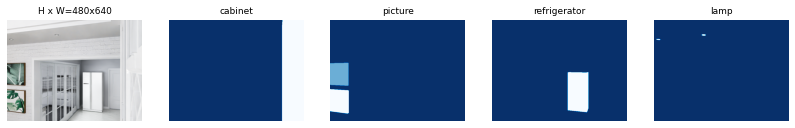

7375


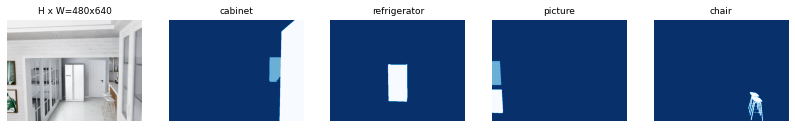

In [8]:
image_ids = dataset_train.load_view(2)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [9]:
class TrainConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.
    vmax = 1.
    grid_dist = 2
    nvox = 100
    nvox_z = 100
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 50
    min_z = 1000
    max_z = 1000
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    DETECTION_MIN_CONFIDENCE = 0.0
    GRID_REAS = 'ident'
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                36
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [10]:
import json
with open(os.path.join(ROOT_DIR,'data/InteriorNet/data/HD7/train/instance_mapping.json')) as json_file:
    instance_map = json.load(json_file)
#print(instance_map)

In [11]:
instance = np.random.choice(list(instance_map.keys()),1)[0]

obj_inst = np.asarray(instance_map[instance])
print(obj_inst.shape)
views = np.random.choice(range(obj_inst.shape[0]),2)
print(views)
image_ids = obj_inst[views][:,1]
print(image_ids)
#print(dataset_train.image_from_source_map)
print(dataset_train.load_view(2))

(7, 2)
[4 3]
['3FO4MC0QPR1B_Dining_room_id7' '3FO4MC0QPR1B_Dining_room_id13']
3FO4MBJUBCJ2_Dining_room_id7
4
[5089, 5092]


In [12]:
# obj_inst = np.array(instance_map['17'])
# image_ids = obj_inst[0:config.NUM_VIEWS][:,1]
# # image_ids = [obj_inst[0][1], obj_inst[20][1]]
# image_ids = np.random.choice(dataset_train.image_ids, config.NUM_VIEWS*1)
image_ids = np.array(dataset_train.load_view(2))
# image_ids = np.array([300, 301])

image_pairs = image_ids.reshape([-1,config.NUM_VIEWS])
print(image_ids)
im = []
Rcam = []
print([config.NUM_VIEWS] + list(config.IMAGE_SHAPE))
# for image_id in image_ids:
#     image_id = dataset_train.image_from_source_map["interior.33FO4JXILITSO_id"+image_id]
#     image = dataset_train.load_image(image_id)
#     image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
#     im.append(image)
#     Rcam.append(dataset_train.load_R(image_id))
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_train.K
    for image_id in image_pair:
        image = dataset_train.load_image(image_id)
        image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
        im.append(image)
        Rcam.append(dataset_train.load_R(image_id))
    im = np.stack(im)
    Rcam = np.stack([Rcam])
    Kmat = np.stack([Kmat])
    print(im.shape)
    print(Rcam.shape)
    print(Kmat.shape)


# Free Memory
del image

from keras.backend.tensorflow_backend import set_session
config_tf = tf.ConfigProto()
config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config_tf)
set_session(sess)  # set this TensorFlow session as the default session for Keras
model = projection1.ProjectionNet(config)
im_res, grid = model.run([[im], Rcam, Kmat])
tf.reset_default_graph()
del model
del sess

3FO4MBFIS3J0_Dining_room_id12
2
[5381 5379]
[2, 640, 640, 3]
(2, 640, 640, 3)
(1, 2, 3, 4)
(1, 3, 3)
nR: 2
grid_range_z:  [100]
1.875
nV:  1000000
rs_grid:  [3, 1000000]
Instructions for updating:
Use tf.cast instead.
nR: 2
grid_range_z:  [100]
1.875
nV:  1000000
rs_grid:  [3, 1000000]
Grid_shape grid_reas: [1, 2, 100, 100, 100, 3]
Grid_shape grid_reas2: [1, 3, 100, 100, 100, 2]
Grid_shape grid_reas_end: [1, 100, 100, 100, 3]
Grid_shape grid_reas: [1, 2, 100, 100, 100, 3]
Grid_shape grid_reas2: [1, 3, 100, 100, 100, 2]
Grid_shape grid_reas_end: [1, 100, 100, 100, 3]


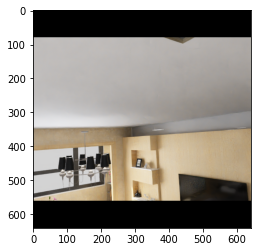

In [13]:
plt.imshow(im[1])
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/original.png'), im[1][:,:,::-1])

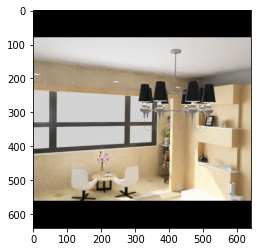

In [14]:
plt.imshow(im[0])

In [15]:
# print(grid.shape)
# unproj = grid[0,0,20,:,:,:]
# plt.imshow(unproj/255)
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/unproj.png'), unproj[:,:,::-1])

(1, 50, 100, 100, 3)


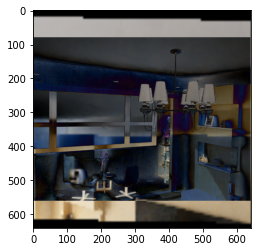

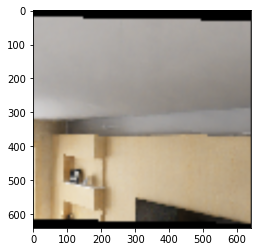

In [22]:
print(im_res.shape)
im_resized, _, _, _, _ = utils.resize_image(im_res[0,25,:,:,:]/255, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
get_ax(size=4)
plt.imshow(np.absolute(im[0]/255-im_resized))
get_ax(size=4)
plt.imshow(im_resized)


In [17]:
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/proj.png'), im_res[0,0,:,:,::-1])

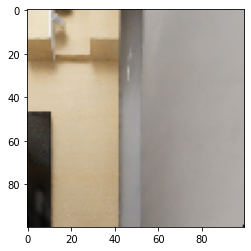

In [18]:
plt.imshow(grid[0,50,:,:,:]/255)